In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GMM
import seaborn as sns
from skimage import transform
from sklearn.datasets import load_digits
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Daten einlesen und vorbereiten

In [2]:
traindata = pd.read_csv("data/zip.train", header=None, sep=" ")
datawithouttargets = traindata.iloc[:,1:-1] #Zeilen ohne Targets und letzte Spalte 
targetcolumn = traindata.iloc[:,0] #nur die Spalte mit den Targets
testdata = pd.read_csv("data/zip.test", header=None, sep=" ") #Datensatz zum Testen der Vorhersage 

## Matrix für das Clustering und die Prüfung

In [3]:
matrixforclustering = traindata.iloc[:,1:-1]
matrixtoproof = traindata.iloc[:,0:-1]

In [4]:
matrixfortesting = testdata.iloc[:,1:]
matrixtoprooftesting = testdata.iloc[:,0:]

## Ergänzen von Daten um die Nachbarschaft zu berücksichtigen 

link: http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rescale
--> downscale_local_mean
a = np.arange(15).reshape(3, 5)
a
array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])
downscale_local_mean(a, (2, 3))
array([[ 3.5,  4. ],
       [ 5.5,  4.5]])

In [5]:
#hier wird die neue Matrix der Durchschnitts-Pixel(256 in hier 64 Pixel) berechnet 
def creatematrixfornewpixel(data,size):
    newmatrix = []
    for i in range(0,len(data)):
        calc3 = np.array(data.loc[i,:]).reshape(16,16)
        calc4 = transform.downscale_local_mean(calc3, (size, size)) ##2,2 bedeutet die neue Größe eines Pixels
        calc5 = calc4.flatten()
        newmatrix.append(calc5)
    return newmatrix

### Matrix mit alten+neuen Parametern 

In [6]:
#für das Clustering: 
size = 2
matrixforclusteringnewpixel = pd.DataFrame(np.concatenate([datawithouttargets.values, creatematrixfornewpixel(datawithouttargets,size)], axis=1)) 
#zur Speicherung der Ergebnisse vom Clustering:
matrixtoproofnewpixel = pd.DataFrame(np.concatenate([pd.DataFrame(targetcolumn), matrixforclusteringnewpixel], axis=1))

### Matrix nur mit den neuen Paramtern 

In [7]:
#für das Clustering: 
matrixforclusteringnewpixelonly = pd.DataFrame(creatematrixfornewpixel(datawithouttargets,size)) #diese Matrix ist für das Clustering
#zur Speicherung der Ergebnisse vom Clustering:
matrixtoproofnewpixelonly = pd.DataFrame(np.concatenate([pd.DataFrame(targetcolumn), matrixforclusteringnewpixelonly], axis=1)) 

## Glättung der Grau-Werte

In [8]:
#für das Clustering: 
matrixforclusteringadjustedgreyscale = (datawithouttargets*4).round()/4

In [9]:
#zur Speicherung der Ergebnisse vom Clustering:
matrixtoproofadjustedgreyscale = pd.DataFrame(np.concatenate([pd.DataFrame(targetcolumn), matrixforclusteringadjustedgreyscale], axis=1))

## Funktionen für das Clustering

In [10]:
numberclusters = 10 # Angabe der Cluster
numberdigits = 10 #Angabe der Zahlen dig
neighbors = 5 #Angabe der Nachbarn für KNN

In [11]:
def firststepclustering (clusteringdata,method):
    if method == "Kmeans":
        result = KMeans(n_clusters=numberclusters,random_state=1).fit(clusteringdata)
    elif method == "Gaussian":
        result = GaussianMixture(n_components=numberclusters,covariance_type='full',n_init=5,random_state=1).fit(clusteringdata)
    elif method == "KNN":
        result = KNeighborsClassifier(n_neighbors=neighbors).fit(clusteringdata,targetcolumn)
    return result

In [12]:
def clustering (clusteringdata,method,proofdata):
    if method == "Kmeans":
        model = firststepclustering (clusteringdata,method)
        proofdata['Kcluster']=model.predict(clusteringdata)
        proofdata['Klabel'] = [["A","B","C","D","E","F","G","H","I","J"][nr] for nr in proofdata['Kcluster']]
    elif method == "Gaussian":
        model = firststepclustering (clusteringdata,method)
        proofdata['Gcluster'] = model.predict(clusteringdata)
        proofdata['Glabel'] = [["A","B","C","D","E","F","G","H","I","J"][nr] for nr in proofdata['Gcluster']]
    elif method == "KNN":
        model = firststepclustering (clusteringdata,method)
        proofdata['KNNlabel'] = model.predict(clusteringdata)
    else: print("please enter a valid method (Gaussian,Kmeans,KNN)")
    return proofdata

In [13]:
def prediction (clusteringdata,method,prooftestdata,testdata):
    if method == "KNN":
        model = firststepclustering (clusteringdata,method)
        prooftestdata['KNNlabel'] = model.predict(testdata)
    elif method == "Kmeans":
        model = firststepclustering (clusteringdata,method)
        prooftestdata['Kcluster']=model.predict(testdata)
        prooftestdata['Klabel'] = [["A","B","C","D","E","F","G","H","I","J"][nr] for nr in prooftestdata['Kcluster']]
    elif method == "Gaussian":
        model = firststepclustering (clusteringdata,method)
        prooftestdata['Gcluster'] = model.predict(testdata)
        prooftestdata['Glabel'] = [["A","B","C","D","E","F","G","H","I","J"][nr] for nr in prooftestdata['Gcluster']]
    return prooftestdata

## Funktionen für die Visualisierungen 

In [14]:
def createtable (method,clusteringdata,proofdata):
    preptableforbarchart = np.zeros((numberdigits,numberclusters))
    if method == "KNN":
        resultmatrixclustering = clustering (clusteringdata,method,proofdata)
        for number in range(0,numberdigits):
                temp_result = resultmatrixclustering[resultmatrixclustering[0] == number].groupby('KNNlabel').count()[0]
                clusters_keys = temp_result.keys()
                for singleGlabel in clusters_keys:
                    tableforbarchart.loc[number][singleGlabel] = temp_result[singleGlabel]
    elif method == "Kmeans" or "Gaussian":
        tableforbarchart = pd.DataFrame(preptableforbarchart, columns=["A","B","C","D","E","F","G","H","I","J"])
        resultmatrixclustering = clustering (clusteringdata,method,proofdata)
        if method == "Kmeans":
            for number in range(0,numberdigits):
                temp_result = resultmatrixclustering[resultmatrixclustering[0] == number].groupby('Klabel').count()[0]
                clusters_keys = temp_result.keys()
                for singleKlabel in clusters_keys:
                     tableforbarchart.loc[number,singleKlabel] = temp_result[singleKlabel]
        elif method == "Gaussian":
            for number in range(0,numberdigits):
                temp_result = resultmatrixclustering[resultmatrixclustering[0] == number].groupby('Glabel').count()[0]
                clusters_keys = temp_result.keys()
                for singleGlabel in clusters_keys:
                    tableforbarchart.loc[number][singleGlabel] = temp_result[singleGlabel]
    else: print("please enter a valid method (Gaussian,Kmeans,KNN)")
    return tableforbarchart

In [15]:
def plottables (method,clusteringdata,proofdata):
    if method == "Kmeans":
        tableK = createtable("Kmeans",clusteringdata,proofdata)
        tableforbarchart_scaled = tableK.divide(tableK.sum(1), axis=0)
        tableforbarchart_transposed_scaled = tableK.T.divide(tableK.T.sum(1), axis=0)
        tabledigits= tableforbarchart_scaled.plot.bar(figsize=(20, 8))
        tablelabels= tableforbarchart_transposed_scaled.plot.bar(figsize=(20, 8))
    elif method == "Gaussian":
        tableG = createtable("Gaussian",clusteringdata,proofdata)
        tableforbarchart_scaled = tableG.divide(tableG.sum(1), axis=0)
        tableforbarchart_transposed_scaled = tableG.T.divide(tableG.T.sum(1), axis=0)
        tabledigits= tableforbarchart_scaled.plot.bar(figsize=(20, 8))
        tablelabels= tableforbarchart_transposed_scaled.plot.bar(figsize=(20, 8))   
    if method == "KNN":
        tableK = createtable("KNN",clusteringdata,proofdata)
        tableforbarchart_scaled = tableK.divide(tableK.sum(1), axis=0)
        tableforbarchart_transposed_scaled = tableK.T.divide(tableK.T.sum(1), axis=0)
        tabledigits= tableforbarchart_scaled.plot.bar(figsize=(20, 8))
        tablelabels= tableforbarchart_transposed_scaled.plot.bar(figsize=(20, 8))
    return tabledigits, tablelabels

In [16]:
def getclustercenters (clusteringdata,method):
    if method == "Kmeans":
        clustercenters = firststepclustering (clusteringdata,"Kmeans").cluster_centers_
    elif method == "Gaussian":
        clustercenters = firststepclustering (clusteringdata,"Gaussian").means_
    elif method == "KNN":
        clustercenters = firststepclustering (clusteringdata,"KNN").means
    return clustercenters

In [17]:
#if clusteringdata.shape[1] > 256:
#clusteringdata = clusteringdata.loc[:,:256]

def visofclustercenters (clusteringdata,method):
    fig, ax = plt.subplots(2, 5, figsize=(8, 3))
    if clusteringdata.shape[1] > 256:
        centersprep = getclustercenters(clusteringdata,method)
        centers = centersprep[:,:256].reshape(10, 16, 16)  
    elif clusteringdata.shape[1] == 16:
        centers = getclustercenters(clusteringdata,method).reshape(10, 4, 4)
    elif clusteringdata.shape[1] == 256:
        centers = getclustercenters(clusteringdata,method).reshape(10, 16, 16)
    elif clusteringdata.shape[1] == 64:
        centers = getclustercenters(clusteringdata,method).reshape(10, 8, 8) 
    for axi, center in zip(ax.flat, centers):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap='hot')

def getNumber(data, clusters):
    data_number = pd.DataFrame(data[data['cluster_idx'] == clusters]) 
    cluster_data = data_number.iloc[:,1:-3]
    return cluster_data

def getNumberImage(data, clusters, aggregation):
    # ruft die Hilfsfunktion getNumber auf um alle Bilddaten Daten zu einer Ziffer zu holen
    image_data = getNumber(data, clusters)
    # bilde aus allen Bildern zu der einen Ziffer ein aggrigiertes Bild
    if(aggregation == 'median'):
        df1 = pd.DataFrame(image_data.median())
    else:
        df1 = pd.DataFrame(image_data.mean())        
    # wandle das format von (1,256) -> (16,16) und gebe diesen transformierten DataFrame zurück
    return df1.values.reshape(16,16)

plt.figure(1, figsize=(20, 10))
for i in range(0,clusters):
    image = getNumberImage(data,i,'median')
    # Call signature: subplot(nrows, ncols, index, **kwargs)
    plt.subplot(3,5, 1 + i)
    plt.imshow(image, cmap='hot', interpolation='none', vmin=-1,vmax=1)
    plt.colorbar (fraction=0.046, pad=0.04)
plt.show()

In [ ]:
visofclustercenters(matrixforclusteringnewpixelonly,"Kmeans")

In [ ]:
visofclustercenters(matrixforclusteringadjustedgreyscale,"Kmeans")

In [ ]:
visofclustercenters(datawithouttargets,"Kmeans")

In [18]:
def calculateaccuracytrain (clusteringdata,method,proofdata):
    rangeinput=np.array([0,1,2,3,4,5,6,7,8,9])
    if method == "Kmeans":
        clustersstep1 = clustering (clusteringdata,method,proofdata)
        clustersstep2 = clustersstep1['Kcluster']
        targets= clustersstep1[0]
        labels = np.zeros_like(clustersstep2)
        for i in range(0, len(rangeinput)):
            mask = (clustersstep2 == rangeinput[i])
            labels[mask] = mode(targets[mask])[0]
    if method == "Gaussian":
        clustersstep1 = clustering (clusteringdata,method,proofdata)
        clustersstep2 = clustersstep1['Gcluster']
        targets= clustersstep1[0]
        labels = np.zeros_like(clustersstep2)
        for i in range(0, len(rangeinput)):
            mask = (clustersstep2 == rangeinput[i])
            labels[mask] = mode(targets[mask])[0]
    if method == "KNN":
        clustersstep1 = clustering (clusteringdata,method,proofdata)
        clustersstep2 = clustersstep1['KNNlabel']
        targets= clustersstep1[0]
        labels = np.zeros_like(clustersstep2)
        for i in range(0, len(rangeinput)):
            mask = (clustersstep2 == rangeinput[i])
            labels[mask] = mode(targets[mask])[0]
    return accuracy_score(targets, labels),pd.DataFrame([targets, clustersstep2,labels]),pd.DataFrame([targets]),pd.DataFrame([labels])

In [19]:
def calculateaccuracytest (clusteringdata,method,prooftestdata,testdata):
    rangeinput=np.array([0,1,2,3,4,5,6,7,8,9])
    if method == "Kmeans":
        clustersstep1 = prediction (clusteringdata,method,prooftestdata,testdata)
        clustersstep2 = clustersstep1['Kcluster']
        targets= clustersstep1[0]
        labels = np.zeros_like(clustersstep2)
        for i in range(0, len(rangeinput)):
            mask = (clustersstep2 == rangeinput[i])
            labels[mask] = mode(targets[mask])[0]
    if method == "Gaussian":
        clustersstep1 = prediction (clusteringdata,method,prooftestdata,testdata)
        clustersstep2 = clustersstep1['Gcluster']
        targets= clustersstep1[0]
        labels = np.zeros_like(clustersstep2)
        for i in range(0, len(rangeinput)):
            mask = (clustersstep2 == rangeinput[i])
            labels[mask] = mode(targets[mask])[0]
    if method == "KNN":
        clustersstep1 = prediction (clusteringdata,method,prooftestdata,testdata)
        clustersstep2 = clustersstep1['KNNlabel']
        targets= clustersstep1[0]
        labels = np.zeros_like(clustersstep2)
        for i in range(0, len(rangeinput)):
            mask = (clustersstep2 == rangeinput[i])
            labels[mask] = mode(targets[mask])[0]
    return accuracy_score(targets, labels),pd.DataFrame([targets, clustersstep2,labels]),pd.DataFrame([targets]),pd.DataFrame([labels])

In [40]:
ACCtrain,acctrainmatrix,traintargets,trainlabels= calculateaccuracytrain (matrixforclustering,"KNN",matrixtoproof)

In [41]:
ACCtrain

0.9791523796461391

In [42]:
ACCtest,acctestmatrix,testtargets,testlabels= calculateaccuracytest (matrixforclustering,"KNN",matrixtoprooftesting,matrixfortesting)

In [43]:
ACCtest

0.9446935724962631

In [23]:
def confusionmatrixtrain (clusteringdata,method,proofdata):
    ACCtrain,acctrainmatrix,traintargets,trainlabels = calculateaccuracytrain (clusteringdata,method,proofdata)
    rangeinput=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    mat = confusion_matrix(np.array(traintargets.T), np.array(trainlabels.T))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=rangeinput,
                yticklabels=rangeinput)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

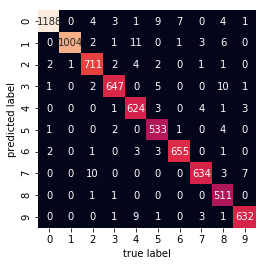

In [26]:
confusionmatrixtrain (matrixforclustering,"KNN",matrixtoproof)

In [20]:
def confusionmatrixtest (clusteringdata,method,prooftestdata,testdata):
    ACC,accmatrix,targets,labels = calculateaccuracytest (clusteringdata,method,prooftestdata,testdata)
    rangeinput=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    mat = confusion_matrix(np.array(targets.T), np.array(labels.T))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=rangeinput,
                yticklabels=rangeinput)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

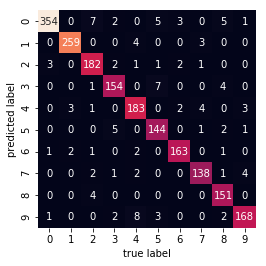

In [21]:
confusionmatrixtest (matrixforclustering,"KNN",matrixtoprooftesting,matrixfortesting)

## Ergebnisse: nur Parameter der Nachbarschaft

### K-Means

In [ ]:
plottables('Kmeans',matrixforclusteringnewpixelonly,matrixtoproofnewpixelonly)
plt.show()

### Gaussian

In [ ]:
plottables('Gaussian',matrixforclusteringnewpixelonly,matrixtoproofnewpixelonly)
plt.show()

## Ergebnisse: alte und neue Parameter der Nachbarschaft

### K-Means

In [ ]:
plottables('Kmeans',matrixforclusteringnewpixel,matrixtoproofnewpixel)
plt.show()

## Gaussian

In [ ]:
plottables('Gaussian',matrixforclusteringnewpixel,matrixtoproofnewpixel)
plt.show()